# House prices predict 

　　Kaggle預測房價競賽網址如下:https://www.kaggle.com/c/house-prices-advanced-regression-techniques
藉由已知房價的1460筆資料，預測另外1458筆資料未知的房價，每一筆資料不含房價共有79個特徵。預測結果以Root-Mean-Squared-Error(RMSE)大小決定成績，目前成績為0.11548，在排行榜 top 9%。

## 1. 資料探索與可視化
### 匯入函式庫

In [1]:
import numpy as np
import pandas as pd

#Encoder
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
%matplotlib inline

#for some statistics
from scipy import stats
from scipy.stats import norm, skew 

#ignore annoying warning (from sklearn and seaborn)
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

### 匯入訓練集與測試集
特徵說明及下載位置請參考:
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [2]:
#import data 
data_org = pd.read_csv('train.csv')
data_test_org = pd.read_csv('test.csv')

#create a copy
data_train = data_org.copy(deep = True)
data_test = data_test_org.copy(deep = True)

### 特徵與房價相關係數

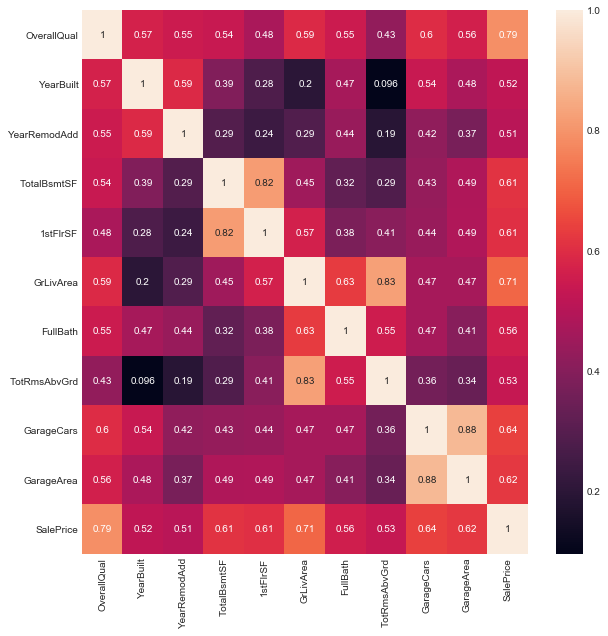

In [3]:
# most correlated features
corrmat = data_train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(data_train[top_corr_features].corr(),annot=True)

### 觀察資料分布

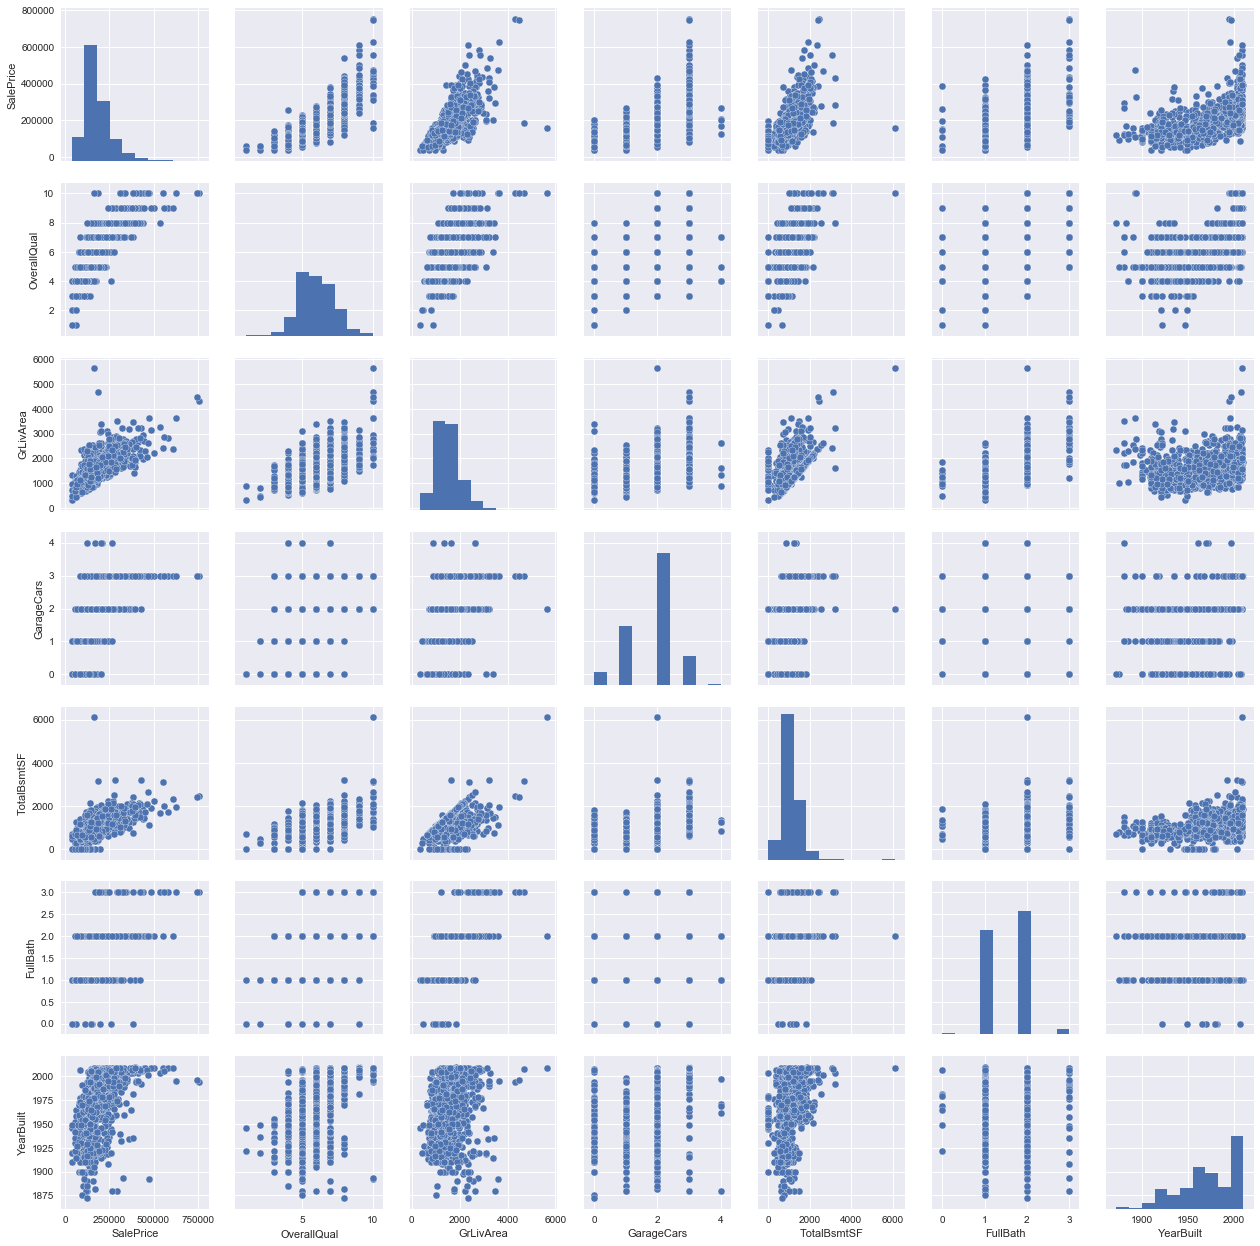

In [4]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(data_train[cols], size = 2.5)
plt.show();

## 2. 數據預處理
### 刪除異常值
在回歸問題中，異常值對模型影響很大，必須刪除。首先繪製GrLivArea與SalePrice的資料分布圖，可以發現整體呈現正相關，但在圖中右下角明顯有兩個樣本偏差較大。

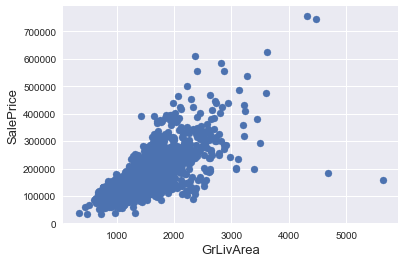

In [5]:
fig, ax = plt.subplots()
ax.scatter(x = data_train['GrLivArea'], y = data_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

接著繪製OverallQual與SalePrice的資料分布圖，可以看到明顯的正相關，但在OverallQual = 4 有一樣本房價特別高，OverallQual = 10 有兩樣本房價特別低(此兩樣本與GrLivArea/SalePrice找出的樣本相同)。

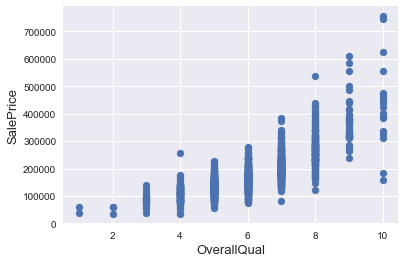

In [6]:
fig, ax = plt.subplots()
ax.scatter(x = data_train['OverallQual'], y = data_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('OverallQual', fontsize=13)
plt.show()

In [7]:
#drop outlier
data_train = data_train.drop(data_train[(data_train['GrLivArea']>4000) & (data_train['SalePrice']<300000)].index)
data_train.drop(data_train[(data_train['OverallQual']<5) & (data_train['SalePrice']>200000)].index, inplace=True)

### 確認資料是否常態分佈


 mu = 180881.40 and sigma = 79470.71



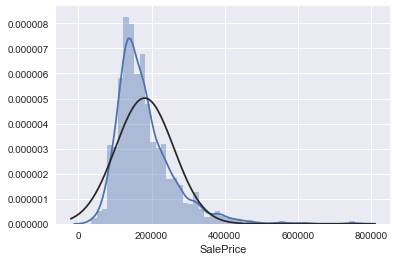

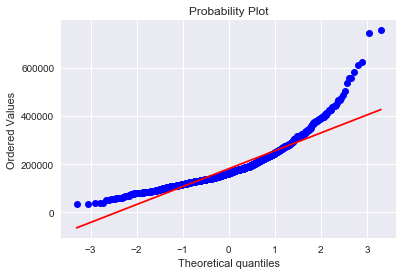

In [8]:
def check_skewness(col):
    sns.distplot(data_train[col] , fit=norm);
    fig = plt.figure()
    res = stats.probplot(data_train[col], plot=plt)
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data_train[col])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    
check_skewness('SalePrice')

### 對房價取log使其接近常態分佈


 mu = 12.02 and sigma = 0.40



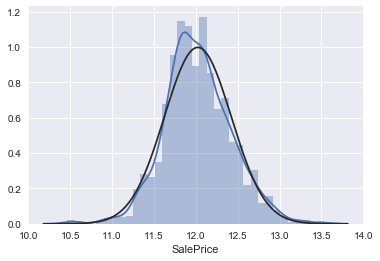

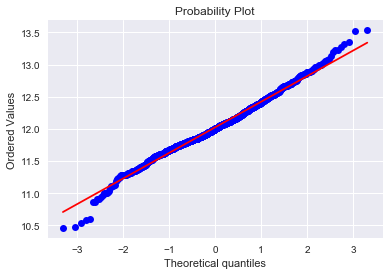

In [9]:
data_train["SalePrice"] = np.log1p(data_train["SalePrice"])

check_skewness('SalePrice')

### 合併train & test data 方便數據清理

In [10]:
price =data_train['SalePrice']
data_train.drop('SalePrice', axis=1, inplace=True)

#keep train & test data length
ntrain = data_train.shape[0]
ntest = data_test.shape[0]

#merge train & test data, so we can clean both datasets at once
dataset = pd.concat([data_train,data_test], axis=0)
dataset = dataset.drop(['Id'], axis=1)
#dataset.info()

### 統計缺失數據

In [11]:
# missing values
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,2907,0.996914
MiscFeature,2811,0.963992
Alley,2718,0.932099
Fence,2345,0.804184
FireplaceQu,1420,0.486968
LotFrontage,485,0.166324
GarageCond,159,0.054527
GarageQual,159,0.054527
GarageYrBlt,159,0.054527
GarageFinish,159,0.054527


### 填補缺失值
由資料說明文件可知，缺失值有兩種情況，一為這個房屋無此特徵，二為真的資料缺失。例如"PoolQC"是游泳池的品質，此特徵缺失可能意味著房屋並沒有游泳池。

下列特徵PoolQC、MiscFeature、Alley、Fence、FireplaceQu缺失皆假設房屋無此特徵，以'None'填補。

In [12]:
# replace those null values with 'None'
dataset["PoolQC"] = dataset["PoolQC"].fillna("None")

dataset["MiscFeature"] = dataset["MiscFeature"].fillna("None")

dataset["Alley"] = dataset["Alley"].fillna("None")

dataset["Fence"] = dataset["Fence"].fillna("None")

dataset["FireplaceQu"] = dataset["FireplaceQu"].fillna("None")

"LotFrontage"為馬路到房屋的距離，像是房屋前的人行道寬度，理論上這個數值會與相鄰房屋相同，故以相同"Neighborhood"的"LotFrontage"中位數填補。

In [13]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
dataset["LotFrontage"] = dataset.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

Garage相關特徵缺失，皆假設房屋無車庫，以'None'填補離散型資料，以0填補數值型資料。

In [14]:
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    dataset[col] = dataset[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    dataset[col] = dataset[col].fillna(0)

Basement相關特徵缺失，皆假設房屋無地下室，以'None'填補離散型資料，以0填補數值型資料。

In [15]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    dataset[col] = dataset[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    dataset[col] = dataset[col].fillna('None')

Masonry veneer相關特徵缺失，皆假設房屋無石工裝飾，以'None'填補離散型資料，以0填補數值型資料。

In [16]:
dataset["MasVnrType"] = dataset["MasVnrType"].fillna("None")
dataset["MasVnrArea"] = dataset["MasVnrArea"].fillna(0)

MSZoning一共有5種類型，'RL'佔了絕大多數，缺失值以出現最多次的'RL'填補。

In [17]:
#print(dataset['MSZoning'].value_counts())
dataset['MSZoning'] = dataset['MSZoning'].fillna(dataset['MSZoning'].mode()[0])

特徵Utilities幾乎所有樣本都是一樣的類型只有一個不同，參考價值不大，故捨棄。

In [18]:
#print(dataset['Utilities'].value_counts())
dataset = dataset.drop(['Utilities'], axis=1)

特徵Functional一共有7種類型，'Typ'佔了絕大多數，缺失值以出現最多次的'Typ'填補。

In [19]:
#print(dataset['Functional'].value_counts())
dataset["Functional"] = dataset["Functional"].fillna("Typ")

下列特徵缺失值以出現最多次的填補。

In [20]:
mode_col = ['Electrical','KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for col in mode_col:
    dataset[col] = dataset[col].fillna(dataset[col].mode()[0])

特徵MSSubClass代表建築類型，缺失值以"None"填補自成一類。

In [21]:
dataset['MSSubClass'] = dataset['MSSubClass'].fillna("None")

下列特徵雖為數值，實際上卻可視為分類，將數值轉換為str以利後續轉換。

In [22]:
#MSSubClass=The building class
dataset['MSSubClass'] = dataset['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
dataset['OverallCond'] = dataset['OverallCond'].astype(str)

用LabelEncoder將下列特徵編碼。

In [23]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
       )

# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(dataset[c].values)) 
    dataset[c] = lbl.transform(list(dataset[c].values))

增加一個新變數TotalSF，代表房屋內主要的總空間。

In [24]:
# Adding total sqfootage feature 
dataset['TotalSF'] = dataset['TotalBsmtSF'] + dataset['1stFlrSF'] + dataset['2ndFlrSF']

numeric_feats = dataset.dtypes[dataset.dtypes != "object"].index

### 將偏度(skew)較大的數值型特徵平滑化

In [25]:
# Check the skew of all numerical features
skewed_feats = dataset[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
#print(skewness.head(15))

skewness = skewness[abs(skewness) > 0.75]
#print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    dataset[feat] = boxcox1p(dataset[feat], lam)

### 離散型特徵以get_dummies編碼

In [26]:
dataset = pd.get_dummies(dataset)
dataset.shape

(2916, 220)

### 分開訓練集與測試集

In [27]:
train = dataset[:ntrain]
test = dataset[ntrain:]
y_train = price
train.shape

(1457, 220)

## 3. 數據分析與評估
### 匯入模型與驗證資料庫

In [28]:
from sklearn.linear_model import ElasticNet, Lasso, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

### 交叉驗證模型
因為特徵的數量不少，故選用有正規化(Regularization)功能的Kernel Ridge作為預測模型，可有效避免overfitting。交叉驗證模型的Root-Mean-Squared-Error(RMSE)及標準差。

In [38]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1149 (0.0074)



### 預測結果

In [39]:
KRRMd = KRR.fit(train.values,y_train)

### 匯出預測結果

In [40]:
sub = pd.DataFrame()
sub['Id'] = data_test['Id']
sub['SalePrice'] = KRRMd
sub.to_csv('house_price_predict.csv',index=False)

### 參考資料

https://www.kaggle.com/apapiu/regularized-linear-models

https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

https://www.kaggle.com/vjgupta/reach-top-10-with-simple-model-on-housing-prices